# <center> Продвинутые фишки PyTorch Lightning 🏋️‍♀️

### Оглавление ноутбука
<img src='../images/overview.jpeg' align="right" width="700" height="428" >
<br>

<p><font size="3" face="Arial" font-size="large"><ul type="square">
    
<li><a href="#p1">🍡 Собираем базовый pipeline!</a></li>
<li>
        <a href="#c33">Фишки, связанные с обучением сетки 🌐</a>
        <ul class="sublist">
            <li><a href="#qstart">🎁 Компиляция модели </a></li>
            <li><a href="#c6">🎲 N-bit Precision</a>
            <li><a href="#c41"> Gradient accumulation 🔋</a>
            <li><a href="#c51"> Gradient clipping 🎬  </a>
        </ul>
    </li>
<li>
        <a href="#c33">Фишки, связанные с инференсом 🏎</a>
        <ul class="sublist">
            <li><a href="#qstart">🔥 ONNX </a></li>
            <li><a href="#c6">TorchScript 🧨</a>
            <li><a href="#c41">Quantization 🧩</a>
        </ul>
    </li>
<li><a href="#p6">🧸 Выводы и заключения ✅ </a></li>


    
</ul></font></p>

<div class="alert alert-success">

В этом ноутбуке мы разберем дополнительные фишки `Lightning`, которые помогут вам обучить тяжелые нейронки и так же посмотрим, как запускать модели в прод версии

# <center> 📚 Бибилиотеки

In [1]:
%%capture
!pip install lightning torchmetrics segmentation-models-pytorch

In [2]:
import os
import warnings
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
import torch
import torchmetrics as tm
from lightning import LightningDataModule, LightningModule, Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset

warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

/app/storage_local/Course/ml_instruments/.venv/lib/python3.10/site-packages/pretrainedmodels/models/dpn.py:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if block_type is 'proj':
/app/storage_local/Course/ml_instruments/.venv/lib/python3.10/site-packages/pretrainedmodels/models/dpn.py:258: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif block_type is 'down':
/app/storage_local/Course/ml_instruments/.venv/lib/python3.10/site-packages/pretrainedmodels/models/dpn.py:262: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert block_type is 'normal'


## <center> 🛠 Конфиг

In [3]:
@dataclass
class CFG:
    folder_path: Path = Path("../data/Cityscapes/cityscapes_data")
    n_classes: int = 35

    arch = "unet"
    enc_name = "efficientnet-b0"

    seed: int = 2025
    device: str = "gpu"  # 'cpu'
    device_count: int = 1

    lr: float = 2e-3
    batch_size: int = 16
    num_workers: int = 2
    epochs: int = 2


cfg = CFG()

## <center> 🎲 Фиксируем seed

In [4]:
from lightning.pytorch import seed_everything

seed_everything(cfg.seed)

Seed set to 2025


2025

# <center> 🤹 Подгружаем данные </center>

<div class="alert alert-info">

Отойдем от табличных данных - потренируемся на данных для сегментации. Возьмем интересный датасет [CityScapes](https://www.cityscapes-dataset.com/)! В нем представлены картинки с беспилотных автомобилей для сегментации объектов города. Если вы не встречались с таким кейсом - кратко можно прочитать [здесь](https://habr.com/ru/companies/data_light/articles/855336/) 🤗

![](https://i.imgur.com/vv3vnpZ.gif)

In [5]:
%%capture
# Скачаем датасет
!mkdir -p ../data
!mkdir -p ../data/Cityscapes
!curl -L -o ../data/cityscapes.zip\
  https://www.kaggle.com/api/v1/datasets/download/dansbecker/cityscapes-image-pairs
!unzip -d ../data/Cityscapes -o ../data/cityscapes.zip
!rm ../data/cityscapes.zip

<div class="alert alert-info" align="center">

Посмотрим на одну из картинок 🧐

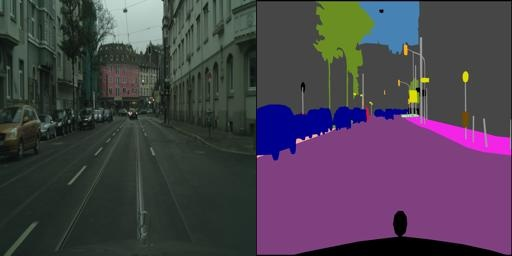

In [5]:
Image.open("../data/Cityscapes/cityscapes_data/train/1000.jpg")

<div class="alert alert-success">

В одной картинки содержится обычная фотография и маска 👺 Поэтому нам придется их разделить

# <center> 🍡 Собираем базовый pipeline! </center>

<div class="alert alert-info">

Определим алгоритм работы нашего `Dataset'a`:
* Разделим картинку на две - `img`, `mask`
* Отнормируем `img`
* Закодируем `mask` в классы для корректной работы loss'а

Алгоритм ясен - давайте писать код!


In [6]:
# Словарь, в котором зашифрована color-map
idx_to_name = [
    "unlabeled",
    "ego vehicle",
    "rectification border",
    "out of roi",
    "static",
    "dynamic",
    "ground",
    "road",
    "sidewalk",
    "parking",
    "rail track",
    "building",
    "wall",
    "fence",
    "guard rail",
    "bridge",
    "tunnel",
    "pole",
    "polegroup",
    "traffic light",
    "traffic sign",
    "vegetation",
    "terrain",
    "sky",
    "person",
    "rider",
    "car",
    "truck",
    "bus",
    "caravan",
    "trailer",
    "train",
    "motorcycle",
    "bicycle",
    "license plate",
]

idx_to_category = [
    "void",
    "flat",
    "construction",
    "object",
    "nature",
    "sky",
    "human",
    "vehicle",
]

idx_to_color = [
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [111, 74, 0],
    [81, 0, 81],
    [128, 64, 128],
    [244, 35, 232],
    [250, 170, 160],
    [230, 150, 140],
    [70, 70, 70],
    [102, 102, 156],
    [190, 153, 153],
    [180, 165, 180],
    [150, 100, 100],
    [150, 120, 90],
    [153, 153, 153],
    [153, 153, 153],
    [250, 170, 30],
    [220, 220, 0],
    [107, 142, 35],
    [152, 251, 152],
    [70, 130, 180],
    [220, 20, 60],
    [255, 0, 0],
    [0, 0, 142],
    [0, 0, 70],
    [0, 60, 100],
    [0, 0, 90],
    [0, 0, 110],
    [0, 80, 100],
    [0, 0, 230],
    [119, 11, 32],
    [0, 0, 142],
]

idx_to_color_np = np.array(idx_to_color)

name_to_category = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 1,
    8: 1,
    9: 1,
    10: 1,
    11: 2,
    12: 2,
    13: 2,
    14: 2,
    15: 2,
    16: 2,
    17: 3,
    18: 3,
    19: 3,
    20: 3,
    21: 4,
    22: 4,
    23: 5,
    24: 6,
    25: 6,
    26: 7,
    27: 7,
    28: 7,
    29: 7,
    30: 7,
    31: 7,
    32: 7,
    33: 7,
    34: 7,
}

In [7]:
name_to_col_mapping = lambda x: idx_to_color[x]
vectorized_col_mapping = np.vectorize(name_to_col_mapping)

name_to_category_mapping = lambda x: name_to_category[x]
vectorized_cat_mapping = np.vectorize(name_to_category_mapping)


# Преобразуем картинку
def preprocess_image(path: str, sparse_mapping=True):
    img = Image.open(path)
    width, height = img.size

    img = np.asarray(img)
    raw, mask = img[:, : width // 2, :], img[:, width // 2 :, :]

    height, width, channels = mask.shape

    distances = np.sum(
        (mask.reshape(-1, channels)[:, np.newaxis, :] - idx_to_color_np) ** 2, axis=2
    )
    classes = np.argmin(distances, axis=1).reshape(height, width)

    if sparse_mapping:
        classes = vectorized_cat_mapping(classes)

    return raw, mask, classes

<div class="alert alert-info">

Базовый датасет выглядит довольно просто 🏋️‍♀️

In [8]:
class CityScapesDataset(Dataset):
    def __init__(self, cfg, split="train"):
        self.cfg = cfg

        self.folder_path = self.cfg.folder_path / split
        self.data_list = sorted(list(self.folder_path.glob("*.jpg")))

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        raw_image, _, classes = preprocess_image(self.data_list[idx])
        image = (raw_image / 255).transpose((2, 0, 1))

        image = torch.Tensor(image)
        mask = torch.Tensor(classes)

        return image, mask

In [9]:
from lightning import LightningDataModule


class CityScapesDatamodule(LightningDataModule):
    def __init__(self, cfg: CFG) -> None:
        super().__init__()

        self.cfg = cfg
        self.batch_size = self.cfg.batch_size

    def setup(self, stage: str):
        # Создаем Dataset'ы
        self.dataset_train = CityScapesDataset(self.cfg, "train")
        self.dataset_valid = CityScapesDataset(self.cfg, "val")

    def _make_dataloader(self, dataset, cfg):
        # Общий метод для создания DataLoader
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            num_workers=self.cfg.num_workers,
            pin_memory=True,
        )

    def train_dataloader(self):
        # Возвращаем Train Dataloader
        return self._make_dataloader(self.dataset_train, cfg)

    def val_dataloader(self):
        # Возвращаем Valid Dataset
        return self._make_dataloader(self.dataset_valid, cfg)

<div class="alert alert-info">

Посмотрим на картинку вместе с маской 🎭

In [10]:
dm = CityScapesDatamodule(cfg)
dm.prepare_data()
dm.setup(stage="fit")

In [12]:
dl = iter(dm.train_dataloader())
sample = next(dl)

In [13]:
images, masks = sample
image, mask = images[0], masks[0]

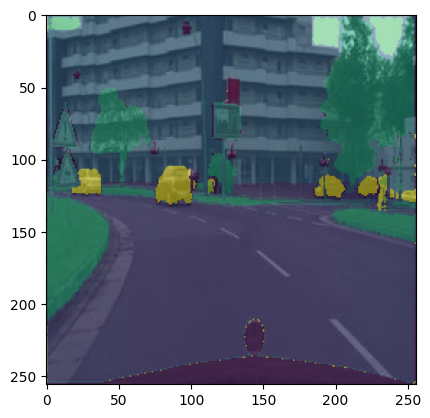

In [15]:
plt.imshow(image.permute(1, 2, 0))
plt.imshow(mask, alpha=0.5)

<div class="alert alert-success">
Добавить комент

# <center> ⚡️ Модель <center>

<div class="alert alert-info">

Чаще всего приходится обучать модель не с нуля, а какими-либо способами **дообучать** ее на своих данных. Так и поступим 😊

Возьмем [UNet](https://paperswithcode.com/method/u-net) из удобной библиотеки [SMP](https://github.com/qubvel-org/segmentation_models.pytorch). Модель не слишком большая, поэтому будем учить все слои модели

In [16]:
import torchmetrics as tm

# Возьмём набор метрик характерных для сегментации
train_metrics = tm.MetricCollection(
    tm.JaccardIndex(task="multiclass", num_classes=cfg.n_classes),
    tm.Dice(num_classes=cfg.n_classes),
    tm.F1Score(task="multiclass", num_classes=cfg.n_classes),
    prefix="train/",
)

valid_metrics = tm.MetricCollection(
    tm.JaccardIndex(task="multiclass", num_classes=cfg.n_classes),
    tm.Dice(num_classes=cfg.n_classes),
    tm.F1Score(task="multiclass", num_classes=cfg.n_classes),
    prefix="valid/",
)

In [17]:
class ScapedModel(LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        # Создаем backbone модель
        self.model = smp.create_model(
            self.cfg.arch,
            encoder_name=self.cfg.enc_name,
            encoder_weights="imagenet",
            in_channels=3,
            classes=self.cfg.n_classes,
            activation=None,
        )

        self.loss_fn = nn.CrossEntropyLoss()

        self.train_metrics = train_metrics
        self.valid_metrics = valid_metrics

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        return self.model(x)

    def basic_step(self, batch, stage):
        images, masks = batch
        out = self.forward(images)

        match stage:
            case "train":
                metrics = self.train_metrics
            case "valid":
                metrics = self.valid_metrics
            case _:
                metrics = self.train_metrics

        y_prob = out.softmax(dim=1)

        metrics.update(y_prob, masks.long())
        calculated_metrics = metrics.compute()
        loss = self.loss_fn(y_prob, masks.long())
        calculated_metrics[f"{stage}/CrossEntropyLoss"] = loss

        self.log_dict(calculated_metrics, prog_bar=True)

        return calculated_metrics

    def training_step(self, batch, batch_idx):
        return self.basic_step(batch, "train")["train/CrossEntropyLoss"]

    def validation_step(self, batch, batch_idx):
        return self.basic_step(batch, "valid")["valid/CrossEntropyLoss"]

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.cfg.lr)
        return [optimizer]

<div class="alert alert-info">

**Обратите внимание: 🥸** Класс нейронной сети практически не изменился!
<br>
Мы поменяли только основную модель, а функции для обучения остались такими же - удобство `Lightning` 🥳

# <center> Переходим к обучению через Trainer 💪

In [18]:
model = ScapedModel(cfg)
dm = CityScapesDatamodule(cfg)

In [ ]:
trainer = Trainer(
    accelerator="gpu",  # Где обучаем нейронку
    devices=cfg.device_count,  # Если несколько GPU, TPU
    fast_dev_run=True,  # Отладочный запуск крайне важен!
)

trainer.fit(model, dm)

In [20]:
# Освободим на всякий случай местсо на GPU
del model, dm
torch.cuda.empty_cache()

In [21]:
model = ScapedModel(cfg)
dm = CityScapesDatamodule(cfg)

In [22]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

trainer = Trainer(
    accelerator="gpu",
    devices=cfg.device_count,
    max_epochs=cfg.epochs,
    log_every_n_steps=10,
    callbacks=[
        EarlyStopping(
            monitor="valid/CrossEntropyLoss",
            verbose=False,
        ),
        ModelCheckpoint(
            monitor="valid/CrossEntropyLoss",
            dirpath=f"../models/{cfg.arch}",
            enable_version_counter=True,
            save_top_k=3,
        ),
    ],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### <center> Посмотрим на затрачиваемые ресурсы - время, память (эмодзи)

In [23]:
%%time
trainer.fit(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | Unet             | 6.3 M  | train
1 | loss_fn       | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | valid_metrics | MetricCollection | 0      | train
4 | softmax       | Softmax          | 0      | train
-----------------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.026    Total estimated model params size (MB)
332       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=2` reached.


CPU times: user 1min 22s, sys: 4.66 s, total: 1min 26s
Wall time: 6min 11s


In [24]:
!nvidia-smi

Thu Feb 20 09:16:28 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.146.02             Driver Version: 535.146.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     Off | 00000000:21:00.0 Off |                  N/A |
|  0%   29C    P8              N/A /  72W |      1MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

<div class="alert alert-success">

Время обучения - **6 минут**
<br>
Потребление памяти - **20gb**

Позже посмотрим, как можно ускорить обучение и сэкономить память вашей видеокарты 😏

### <center> Видит ли модель машины? 🧐

In [25]:
outs = model(images)
y_pred = outs.argmax(dim=1)

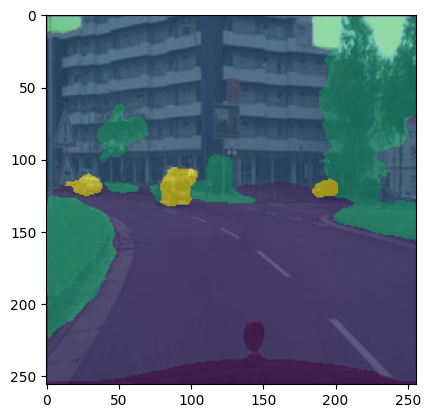

In [26]:
plt.imshow(images[0].permute((1, 2, 0)))
plt.imshow(y_pred[0], alpha=0.6)

In [27]:
del model, dm
torch.cuda.empty_cache()

In [28]:
!nvidia-smi

Thu Feb 20 09:19:22 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.146.02             Driver Version: 535.146.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     Off | 00000000:21:00.0 Off |                  N/A |
|  0%   29C    P8              N/A /  72W |      1MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

<div class="alert alert-info" align="center">

Мы собрали рабочий baseline (эмодзи)
<br>
Картинку справа, текст слева
<img src="https://i.imgur.com/1UFn5ew.gif">

Далее соберем более продвинутое решение

<div class="alert alert-success">

Фишек очень много, поэтому рассмотрим их по блокам:

- Лайфхаки при обучении сетки
- Быстрый инференс на CPU, GPU
- Мельком посмотрим на то, как запускать модель в API

## <center> Фишки, связанные с обучением сетки 🌐

### <center> 🎁 Компиляция модели

<div class="alert alert-info">

Для чего нужна компиляция модели? 🤨
- **Ускорение вычислений**: Компиляция преобразует ваш код в оптимизированные низкоуровневые операции, что особенно полезно для больших моделей и данных.
- **Аппаратная оптимизация**: Использует возможности `GPU/TPU` эффективнее (например, `fused kernels` для матричных операций).


<div class="alert alert-info">

Заметная разница будет на кластере с 8+ GPU и если видеокарты новые от поколения `Ampere`. У нас таких мощностей нет, но рассмотреть стоит! 🤗

In [31]:
model = ScapedModel(cfg)
dm = CityScapesDatamodule(cfg)

In [32]:
# Компилируем нашу модель
model_compiled = torch.compile(model)

In [33]:
trainer = Trainer(
    accelerator="gpu",
    devices=cfg.device_count,
    max_epochs=cfg.epochs,
    log_every_n_steps=10,
    callbacks=[
        EarlyStopping(
            monitor="valid/CrossEntropyLoss",
            verbose=False,
        ),
        ModelCheckpoint(
            monitor="valid/CrossEntropyLoss",
            dirpath=f"../models/{cfg.arch}",
            enable_version_counter=True,
            save_top_k=3,
        ),
    ],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [34]:
# %%time
# trainer.fit(model_compiled, dm)

In [35]:
# del model, dm
# torch.cuda.empty_cache()

In [36]:
trainer = Trainer(
    accelerator="gpu",
    devices=cfg.device_count,
    max_epochs=cfg.epochs,
    log_every_n_steps=10,
    callbacks=[
        EarlyStopping(
            monitor="valid/CrossEntropyLoss",
            verbose=False,
        ),
        ModelCheckpoint(
            monitor="valid/CrossEntropyLoss",
            dirpath=f"../models/{cfg.arch}",
            enable_version_counter=True,
            save_top_k=3,
        ),
    ],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [37]:
# %%time
# trainer.fit(model, dm)

In [38]:
# del model, dm
# torch.cuda.empty_cache()

## <center> 🎲 N-bit Precision

<div class="alert alert-info">

`N-bit Precision` — это использование весов с пониженной битностью (меньше 32 бит) для ускорения вычислений и сокращения потребления памяти. В `Lightning` этот параметр можно настроить через `precision` в `Trainer`.
Основные типы точности:

- **FP32 (32-битная)**:<br>
Стандартный формат для обучения. Высокая точность, но требует много памяти и вычислительных ресурсов.

- **FP16 (16-битная)**:
В 2 раза меньше памяти, ускоряет матричные операции на GPU.
**Риск переполнения/недополнения** (числа вне диапазона ±65,504 теряются)

- **BF16 (Brain Floating Point)**:
    16 бит, но с большим диапазоном, чем FP16 (как у FP32).
    Стабильнее для обучения, но менее точный в дробной части.
    Поддерживается современными GPU (например, NVIDIA A100, TPU).

- **INT8 (8-битная)**:
        Используется для квантования моделей (сжатие после обучения).
        Сильно сокращает размер модели, но требует калибровки данных.
        Чаще применяется на этапе инференса (вывода), а не обучения.


<div class="alert alert-success" align="center">
Мини-схемка о том, как работает precision в памяти:

<img src="https://i.imgur.com/Fn33CBd.jpeg" align="center"> </img>

In [39]:
model = ScapedModel(cfg)
dm = CityScapesDatamodule(cfg)

In [40]:
trainer = Trainer(
    accelerator="gpu",
    devices=cfg.device_count,
    max_epochs=cfg.epochs,
    log_every_n_steps=10,
    precision="16-mixed",  # с какой точностью хранятся веса
    callbacks=[
        EarlyStopping(
            monitor="valid/CrossEntropyLoss",
            verbose=False,
        ),
        ModelCheckpoint(
            monitor="valid/CrossEntropyLoss",
            dirpath=f"../models/{cfg.arch}",
            enable_version_counter=True,
            save_top_k=3,
        ),
    ],
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [41]:
%%time
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | Unet             | 6.3 M  | train
1 | loss_fn       | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | valid_metrics | MetricCollection | 0      | train
4 | softmax       | Softmax          | 0      | train
-----------------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.026    Total estimated model params size (MB)
332       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


CPU times: user 38.5 s, sys: 5.42 s, total: 43.9 s
Wall time: 6min 55s


<div class="alert alert-info">
    
Стоит быть осторожным с использованием `precision` в `Trainer`: некоторые типы весов могут быть использованы только на определенных устройствах: <br>

![](https://i.imgur.com/mjtQIlT.png)

In [42]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   4096 B   |   3728 MiB |   9782 GiB |   9782 GiB |
|       from large pool |      0 B   |   3666 MiB |   9718 GiB |   9718 GiB |
|       from small pool |   4096 B   |     77 MiB |     64 GiB |     64 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   4096 B   |   3728 MiB |   9782 GiB |   9782 GiB |
|       from large pool |      0 B   |   3666 MiB |   9718 GiB |

## <center> Gradient accumulation 🔋

<div class="alert alert-info">

**Gradient Accumulation** (Накопление градиентов)

**Что это?** 
Техника, позволяющая имитировать большой размер батча при ограниченных ресурсах GPU. Вместо обновления весов после каждого батча, градиенты накапливаются за несколько шагов, и обновление происходит только после нескольких итераций

<div class="alert alert-info">
    
**Зачем нужно?** 
* Экономия памяти GPU: Если большой батч не помещается в память, его можно разбить на мини-батчи.
* Стабильность обучения: Большой эффективный батч дает менее шумные оценки градиента.

`Gradient Accumulation` - можно включить, добавив гиперпараметр `accumulate_grad_batches` в `Trainer`. `accumulate_grad_batches` должен быть >= 1, при значении 1 - накопление будет происходить через 1 шаг.

In [49]:
model = ScapedModel(cfg)
dm = CityScapesDatamodule(cfg)

In [50]:
trainer = Trainer(
    accelerator="gpu",
    devices=cfg.device_count,
    max_epochs=cfg.epochs,
    log_every_n_steps=10,
    accumulate_grad_batches=2,  # Добавляем gradient accumulation
    callbacks=[
        EarlyStopping(
            monitor="valid/CrossEntropyLoss",
            verbose=False,
        ),
        ModelCheckpoint(
            monitor="valid/CrossEntropyLoss",
            dirpath=f"../models/{cfg.arch}",
            enable_version_counter=True,
            save_top_k=3,
        ),
    ],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [51]:
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | Unet             | 6.3 M  | train
1 | loss_fn       | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | valid_metrics | MetricCollection | 0      | train
4 | softmax       | Softmax          | 0      | train
-----------------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.026    Total estimated model params size (MB)
332       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [52]:
del model, dm
torch.cuda.empty_cache()

## <center>  Gradient clipping 🎬

<div class="alert alert-info">

**Gradient Clipping** (Отсечение градиентов)

**Что это?**  
Техника для предотвращения взрыва градиентов (особенно в `RNN`, `Transformers`). Если норма градиентов превышает заданный порог, они масштабируются, чтобы остаться в допустимых пределах.

<div class="alert alert-info">

**Зачем нужно?**
* Стабилизация обучения: Защищает от резкого изменения весов.
* Защита от `NaN`: Предотвращает числовую нестабильность.

In [53]:
model = ScapedModel(cfg)
dm = CityScapesDatamodule(cfg)

In [54]:
trainer = Trainer(
    accelerator="gpu",
    devices=cfg.device_count,
    max_epochs=cfg.epochs,
    log_every_n_steps=10,
    accumulate_grad_batches=0.5,  # Добавляем gradient clipping
    callbacks=[
        EarlyStopping(
            monitor="valid/CrossEntropyLoss",
            verbose=False,
        ),
        ModelCheckpoint(
            monitor="valid/CrossEntropyLoss",
            dirpath=f"../models/{cfg.arch}",
            enable_version_counter=True,
            save_top_k=3,
        ),
    ],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [55]:
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | Unet             | 6.3 M  | train
1 | loss_fn       | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | valid_metrics | MetricCollection | 0      | train
4 | softmax       | Softmax          | 0      | train
-----------------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.026    Total estimated model params size (MB)
332       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


## <center> Фишки, связанные с инференсом 🏎

### <center> ONNX 🔥

<div class="alert alert-info">

`ONNX` (Open Neural Network Exchange) — открытый формат для представления моделей,позволяет конвертировать модели между фреймворками (`PyTorch`, `JAX`, `TensorFlow`, и др.) и выполнять их запуск в других библиотеках

<div class="alert alert-info">

**Когда применять `ONNX`?**

- Развертывание моделей на прод:
    Часто бывает, что запуском моделей занимаются другие люди, поэтому удобно иметь единый интерфейс с запуском ваших моделей. Также запуск модельки на других языках - больше не проблема, так как `ONNX` портирован на большинство популярных языков: `C++`, `Java`, `C#` и др.
- Оптимизация производительности:
    Использование `ONNX Runtime` может значительно ускорить inference модели на `CPU`, что очень удобно для высоконагруженных сервисов

In [ ]:
# Сохраним нашу модель в ONNX, вызвав один метод to_onnx

input_sample = torch.randn(
    (1, 3, 256, 256)
)  # Сгенерируем рандомный sample. Главное, чтобы совподали размерности!

model.to_onnx(
    f"../models/{cfg.arch}/model.onnx",  # Путь до модели
    input_sample,  # Входной сигнал
    export_params=True,  # Сохраним веса в тот же файлик
)

<div class="alert alert-warning">

<p style="text-align:center">
Обязательно проверяйте модель 👺
</p>

Прежде чем передать модель на следующий этап - проверьте запускается ли она. Чем решать 10 проблем с запуском модели на проде, лучше 1 раз проверить их локально 🤫

In [58]:
import onnxruntime

ort_session = onnxruntime.InferenceSession(f"../models/{cfg.arch}/model.onnx")
input_name = ort_session.get_inputs()[0].name

In [59]:
ort_inputs = {input_name: np.random.randn(1, 3, 256, 256).astype(np.float32)}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs

[array([[[[ 7.18365335e+00,  6.14463949e+00,  3.15818238e+00, ...,
            1.17821288e+00,  1.10285473e+00,  1.40104443e-01],
          [ 4.58292198e+00, -3.12713146e-01, -4.59808111e+00, ...,
           -8.34873104e+00, -7.05956316e+00, -4.71376467e+00],
          [ 1.29986870e+00, -3.81807137e+00, -8.46767998e+00, ...,
           -1.20189857e+01, -1.00243769e+01, -6.66246271e+00],
          ...,
          [ 1.20419550e+00, -2.90076303e+00, -6.19933271e+00, ...,
           -3.83040667e+00, -2.47754192e+00, -1.07061458e+00],
          [ 2.56163430e+00, -1.38194561e-01, -3.52398777e+00, ...,
           -1.15435052e+00,  3.38316336e-03,  3.07211280e-01],
          [ 1.25956857e+00, -2.45012522e-01, -2.03076124e+00, ...,
           -5.91735244e-01,  6.60605431e-02,  1.58486605e-01]],
 
         [[-5.27985382e+00, -5.96666670e+00, -6.06961632e+00, ...,
           -6.69250870e+00, -6.26890469e+00, -4.48334789e+00],
          [-6.11691761e+00, -6.81140757e+00, -7.44140005e+00, ...,
     

## <center> TorchScript 🧨

<div class="alert alert-info">

`TorchScript` - модуль `PyTorch` для сериализации моделей в формат, независимый от Python. Позволяет выполнять модели в средах без Python (C++, мобильные устройства) через `JIT`-компиляцию. Поддерживает два режима: `tracing` (запись графа через пример данных) и `scripting` (явное описание логики с сохранением динамики).

<div class="alert alert-info">

**Принципиальные отличия от `ONNX`**
- Цель использования:
    TorchScript — оптимизация и деплой моделей ТОЛЬКО `PyTorch`. Поэтому и ее запуск предполагает использование `PyTorch`.
    В то же время `ONNX` — стандарт, который поддерживает обучение модели на `PyTorch`, а ее запуск наа `TensorFlow.js`

- Гибкость графа вычислений:
    `TorchScript` лучше сохраняет динамические операции (условия, циклы) через режим `scripting`.
    `ONNX`лучше работает на статических графах, но в современных версиях (после 15) стали поддерживать динамические операции

- Оптимизация:
    `TorchScript` использует оптимизации `PyTorch` (например, `fusion` операций для GPU).
    `ONNX` полагается на внешние рантаймы (например, `ONNX Runtime` с поддержкой квантования)

In [ ]:
# Сохраним нашу модель в ONNX, вызвав один метод to_torchscript
torch.jit.save(
    model.to_torchscript(
        file_path=f"../models/{cfg.arch}/model.pt",
        method="tracing",
        example_inputs=torch.randn(1, 3, 256, 256),
    )
)

<div class="alert alert-warning">

Опять же - проверяйте модель!

In [ ]:
inp = torch.rand(1, cfg.num_features)
scripted_module = torch.jit.load(f"../models/{cfg.arch}/model.pt")
output = scripted_module(inp)
output

# <center> 🧸 Выводы и заключения ✅

<div class="alert alert-success">
    
**В этом уроке:**
- Изучили продвинутые фишки `lightning` для тренировки моделей, теперь легко сможете контролировать процесс обучения в зависимости от доступных ресурсов.
- Узнали какие есть фишки в `lightning` для ускорения инференса моделей, и простого переезда обученной модели на другие фреймворки, среды исполнения, ресурсы.

<div class="alert alert-info">
    
- И для всех этих действий понадобится добавить один гиперпараметр в обучение или пару строк кода!
- Для эффективного обучения модели есть ...
- Для ускорения инференса модели есть ....